In [1]:
import os
from glob import glob
import numpy as np
import dask
import xarray as xr
from matplotlib import pyplot as plt
%matplotlib inline

import xrft

from mitequinox.utils import *

/home1/datahome/xyu/.miniconda3/envs/equinox/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home1/datahome/xyu/.miniconda3/envs/equinox/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home1/datahome/xyu/.miniconda3/envs/equinox/lib/python3.6/site-packages/cmocean/tools.py:76: MatplotlibDeprecationWarning: The is_string_like function was deprecated in version 2.1.
  if not mpl.cbook.is_string_like(rgbin[0]):


In [2]:
from dask_jobqueue import PBSCluster
local_dir = os.getenv('TMPDIR')
cluster = PBSCluster(local_directory=local_dir)
w = cluster.start_workers(5)

/home1/datahome/xyu/.miniconda3/envs/equinox/lib/python3.6/site-packages/distributed/utils.py:128: RuntimeWarning: Couldn't detect a suitable IP address for reaching '8.8.8.8', defaulting to '127.0.0.1': [Errno 101] Network is unreachable
  % (host, default, e), RuntimeWarning)


In [3]:
# get dask handles and check dask server status
from dask.distributed import Client
client = Client(cluster)

In [4]:
client

Client Scheduler: tcp://10.148.1.11:52051 Dashboard: http://10.148.1.11:8787/status,Cluster Workers: 2 Cores: 8 Memory: 100.00 GB


In [45]:
v_u = 'SSU'
## data files (SSU,SSV) ##
data_dir = '/home1/scratch/xyu/mit_zarr/UV/LLC1080/'

In [46]:
# grid file
mgrid = xr.open_dataset('/home1/scratch/xyu/grid/mit_grid_t_1080.nc')
mgrid = mgrid.drop(['XG','YG','i_g','j_g','dxG','dyG','dxC','dyC','rAw','rAs','rAz'])
print(mgrid)

<xarray.Dataset>
Dimensions:  (face: 13, i: 1080, j: 1080)
Coordinates:
  * i        (i) int64 0 4 8 12 16 20 24 28 32 36 40 44 48 52 56 60 64 68 72 ...
  * j        (j) int64 0 4 8 12 16 20 24 28 32 36 40 44 48 52 56 60 64 68 72 ...
  * face     (face) int64 0 1 2 3 4 5 6 7 8 9 10 11 12
    XC       (face, i, j) float32 ...
    YC       (face, i, j) float32 ...
    CS       (face, i, j) float32 ...
    SN       (face, i, j) float32 ...
    rA       (face, i, j) float32 ...
    Depth    (face, i, j) float32 ...
Data variables:
    *empty*
Attributes:
    Conventions:  CF-1.6
    title:        netCDF wrapper of MITgcm MDS binary data
    source:       MITgcm
    history:      Created by calling `open_mdsdataset(llc_method='smallchunks...


In [48]:
## Here we do DFT on u+iv ##
time_chunk = 8640
ij_chunk = 108

face = 1    
# Grid #
grid = mgrid.isel(face=face)
    
# Read SSU #
ds_SSU = xr.open_zarr(data_dir+'SSU_f%02d.zarr'%(face)).rename({'i_g': 'i'})
chunks={'time': time_chunk, 'i': ij_chunk, 'j': ij_chunk} # time chunck: (1 months)
ds_SSU = ds_SSU.chunk(chunks) 
# Read SSV #

# Merge into one xarray dataset #
ds = xr.merge([ds_SSU, grid])    
print(ds)
print('\n data size: %.1f GB' %(ds.nbytes / 1e9))

ValueError: group not found at path ''

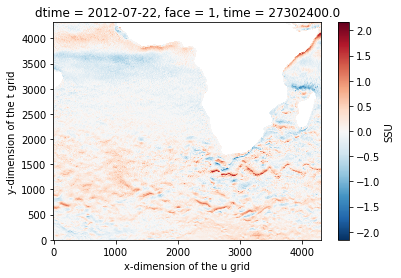

In [8]:
ds['SSU'].isel(time=6000).plot(x='i',y='j')

In [29]:
%time SSU1 = ds['SSU'].isel(i=500,j=250).persist()

CPU times: user 852 ms, sys: 4 ms, total: 856 ms
Wall time: 853 ms


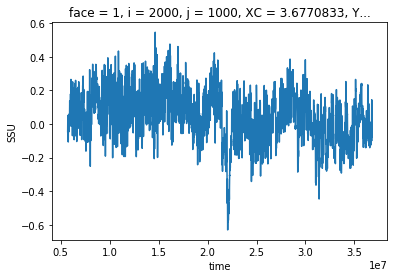

In [10]:
SSU1.plot()

In [30]:
E_1_segments = xrft.power_spectrum(SSU1.fillna(0.), dim=['time'], window=True, detrend='linear')
print(E_1_segments)
#E_1 = E_1_segments.mean(dim=['time_segment']) 

<xarray.DataArray 'rechunk-merge-db13a65114c73a050e2399e4c5ee7341' (freq_time: 8640)>
dask.array<shape=(8640,), dtype=float64, chunksize=(8640,)>
Coordinates:
  * freq_time          (freq_time) float64 -0.0001389 -0.0001389 -0.0001388 ...
    freq_time_spacing  float64 3.215e-08


In [12]:
E_2_segments = xrft.dft(SSU1.fillna(0.), dim=['time'], shift=False, detrend='constant', window=True) 
E_uv_segments = (E_2_segments*E_2_segments.conj()).where(E_2_segments!=0., drop=False)/8640*3600    
print(E_uv_segments)
#E_2 = E_uv_segments.mean(dim=['time_segment']) 

<xarray.DataArray 'fftn-0580219ad92895dbcf306c806218cc16' (freq_time: 8640)>
dask.array<shape=(8640,), dtype=complex128, chunksize=(8640,)>
Coordinates:
  * freq_time          (freq_time) float64 0.0 3.215e-08 6.43e-08 9.645e-08 ...
    freq_time_spacing  float64 3.215e-08


/home1/datahome/xyu/.miniconda3/envs/equinox/lib/python3.6/site-packages/numpy/core/numeric.py:501: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
No handles with labels found to put in legend.


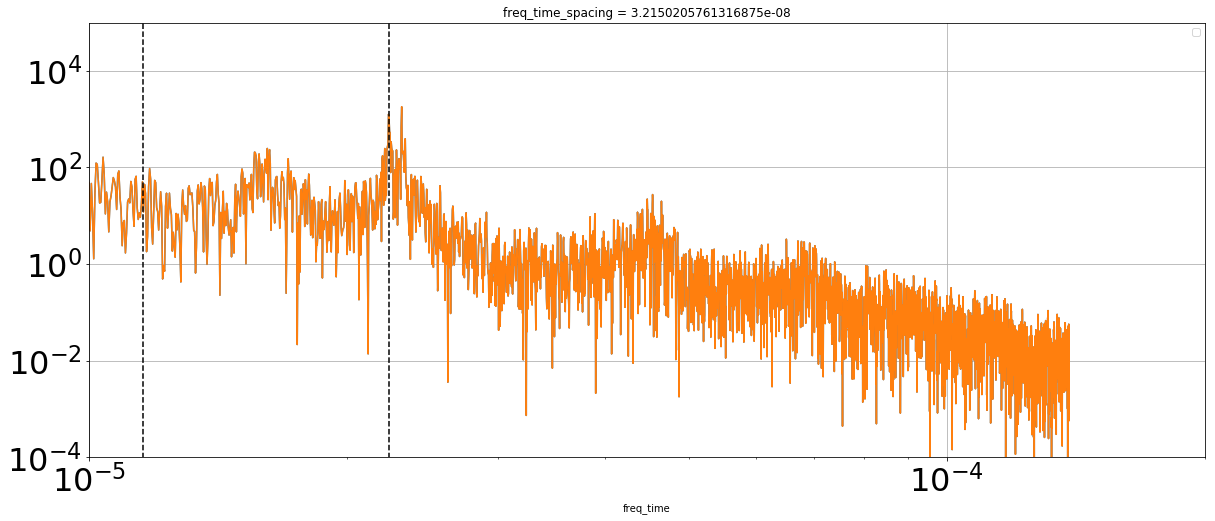

In [14]:
fig, ax = plt.subplots(figsize=(20,8))
E_1_segments.where(E_1_segments.freq_time>0).plot(ax=ax)
E_uv_segments.where(E_uv_segments.freq_time>0).plot(ax=ax)

ax.legend(); ax.grid()
ax.set_xscale('log'); ax.set_yscale('log')
ax.set_ylabel(''); 

ax.set_xlim([1e-5,2*1e-4])
ax.set_ylim([1e-4,1e5])


# M2 #
ax.plot([1/12.42/3600,1/12.42/3600],[1e-5,1e5],'k--') 

# K1 #
ax.plot([1/24/3600,1/24/3600],[1e-5,1e5],'k--')

ax.tick_params(labelsize=32)

______

# Segments

In [100]:
## Here we do DFT on u+iv ##
time_chunk = 1080
ij_chunk = 108

face = 1    
# Grid #
grid = mgrid.isel(face=face)
    
# Read SSU #
ds_SSU = xr.open_zarr(data_dir+'SSU_f%02d.zarr'%(face)).rename({'i_g': 'i'})
chunks={'time': time_chunk, 'i': ij_chunk, 'j': ij_chunk} # time chunck: (1 months)
ds_SSU = ds_SSU.chunk(chunks) 
# Read SSV #

# Merge into one xarray dataset #
ds = xr.merge([ds_SSU, grid])    
print(ds)
print('\n data size: %.1f GB' %(ds.nbytes / 1e9))

<xarray.Dataset>
Dimensions:  (i: 1080, j: 1080, time: 8640)
Coordinates:
    dtime    (time) datetime64[ns] dask.array<shape=(8640,), chunksize=(1080,)>
    face     int64 1
  * i        (i) int64 0 4 8 12 16 20 24 28 32 36 40 44 48 52 56 60 64 68 72 ...
  * j        (j) int64 0 4 8 12 16 20 24 28 32 36 40 44 48 52 56 60 64 68 72 ...
  * time     (time) float64 5.702e+06 5.706e+06 5.71e+06 5.713e+06 5.717e+06 ...
    XC       (i, j) float32 ...
    YC       (i, j) float32 ...
    CS       (i, j) float32 ...
    SN       (i, j) float32 ...
    rA       (i, j) float32 ...
    Depth    (i, j) float32 ...
Data variables:
    SSU      (time, j, i) float32 dask.array<shape=(8640, 1080, 1080), chunksize=(1080, 108, 108)>

 data size: 40.3 GB


In [101]:
%time SSU1 = ds['SSU'].isel(i=500,j=250).persist()
print(SSU1)

CPU times: user 948 ms, sys: 4 ms, total: 952 ms
Wall time: 948 ms
<xarray.DataArray 'SSU' (time: 8640)>
dask.array<shape=(8640,), dtype=float32, chunksize=(1080,)>
Coordinates:
    dtime    (time) datetime64[ns] dask.array<shape=(8640,), chunksize=(1080,)>
    face     int64 1
    i        int64 2000
    j        int64 1000
  * time     (time) float64 5.702e+06 5.706e+06 5.71e+06 5.713e+06 5.717e+06 ...
    XC       float32 ...
    YC       float32 ...
    CS       float32 ...
    SN       float32 ...
    rA       float32 ...
    Depth    float32 ...


In [102]:
E_1_segments = xrft.power_spectrum(SSU1.fillna(0.), dim=['time'], shift=False, detrend='constant', density=False, window=True, chunks_to_segments=True)
print(E_1_segments)
E_1 = E_1_segments.mean(dim=['time_segment']) 
print(E_1)

<xarray.DataArray 'fftn-5b245d6f84aa81790a82837e4acd612e' (time_segment: 8, freq_time: 1080)>
dask.array<shape=(8, 1080), dtype=float64, chunksize=(1, 1080)>
Coordinates:
  * time_segment       (time_segment) int64 0 1 2 3 4 5 6 7
  * freq_time          (freq_time) float64 0.0 2.572e-07 5.144e-07 7.716e-07 ...
    freq_time_spacing  float64 2.572e-07
<xarray.DataArray 'fftn-5b245d6f84aa81790a82837e4acd612e' (freq_time: 1080)>
dask.array<shape=(1080,), dtype=float64, chunksize=(1080,)>
Coordinates:
  * freq_time          (freq_time) float64 0.0 2.572e-07 5.144e-07 7.716e-07 ...
    freq_time_spacing  float64 2.572e-07


In [103]:
E_2_segments = xrft.dft(SSU1.fillna(0.), dim=['time'], shift=False, detrend='constant', window=True, chunks_to_segments=True) 
E_uv_segments = (E_2_segments*E_2_segments.conj()).where(E_2_segments!=0., drop=False)/time_chunk*3600    
print(E_uv_segments)
E_2 = E_uv_segments.mean(dim=['time_segment']) 
print(E_2)

<xarray.DataArray 'fftn-5b245d6f84aa81790a82837e4acd612e' (time_segment: 8, freq_time: 1080)>
dask.array<shape=(8, 1080), dtype=complex128, chunksize=(1, 1080)>
Coordinates:
  * time_segment       (time_segment) int64 0 1 2 3 4 5 6 7
  * freq_time          (freq_time) float64 0.0 2.572e-07 5.144e-07 7.716e-07 ...
    freq_time_spacing  float64 2.572e-07
<xarray.DataArray 'fftn-5b245d6f84aa81790a82837e4acd612e' (freq_time: 1080)>
dask.array<shape=(1080,), dtype=complex128, chunksize=(1080,)>
Coordinates:
  * freq_time          (freq_time) float64 0.0 2.572e-07 5.144e-07 7.716e-07 ...
    freq_time_spacing  float64 2.572e-07


/home1/datahome/xyu/.miniconda3/envs/equinox/lib/python3.6/site-packages/numpy/core/numeric.py:501: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


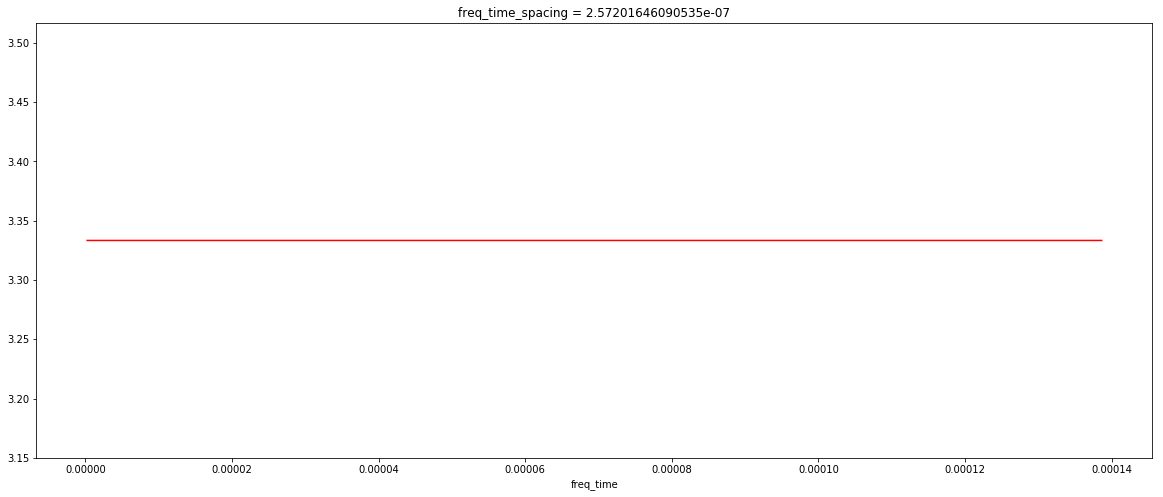

In [104]:
fig, ax = plt.subplots(figsize=(20,8))
(E_2/E_1).where(E_2.freq_time>0).plot(ax=ax,color='red')

/home1/datahome/xyu/.miniconda3/envs/equinox/lib/python3.6/site-packages/numpy/core/numeric.py:501: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
No handles with labels found to put in legend.


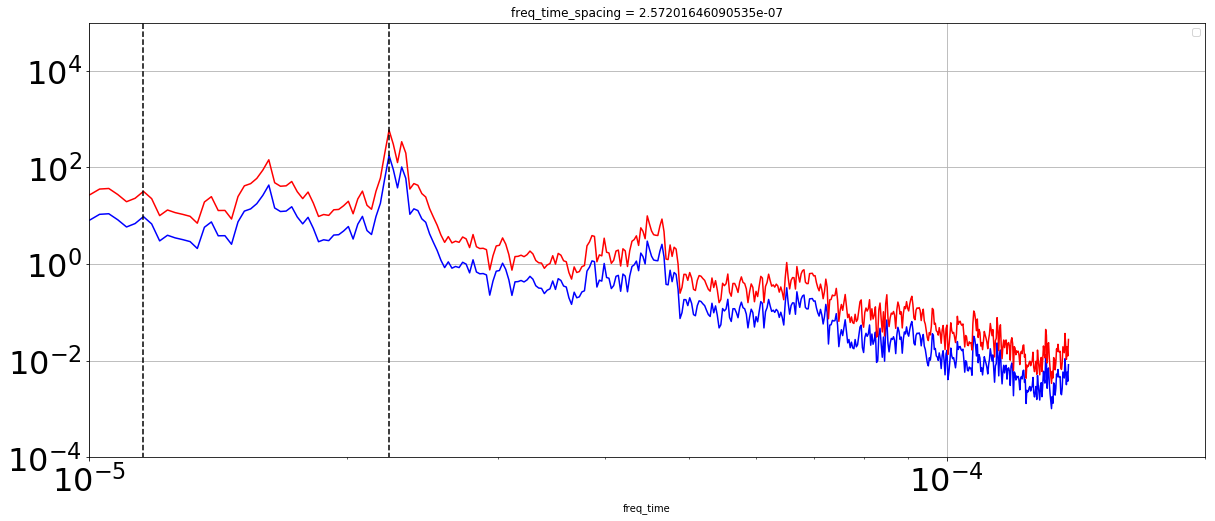

In [105]:
fig, ax = plt.subplots(figsize=(20,8))
(E_1).where(E_1.freq_time>0).plot(ax=ax,color='blue')
(E_2).where(E_2.freq_time>0).plot(ax=ax,color='red')

ax.legend(); ax.grid()
ax.set_xscale('log'); ax.set_yscale('log')
ax.set_ylabel(''); 

ax.set_xlim([1e-5,2*1e-4])
ax.set_ylim([1e-4,1e5])


# M2 #
ax.plot([1/12.42/3600,1/12.42/3600],[1e-5,1e5],'k--') 

# K1 #
ax.plot([1/24/3600,1/24/3600],[1e-5,1e5],'k--')

ax.tick_params(labelsize=32)

/home1/datahome/xyu/.miniconda3/envs/equinox/lib/python3.6/site-packages/numpy/core/numeric.py:501: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
No handles with labels found to put in legend.


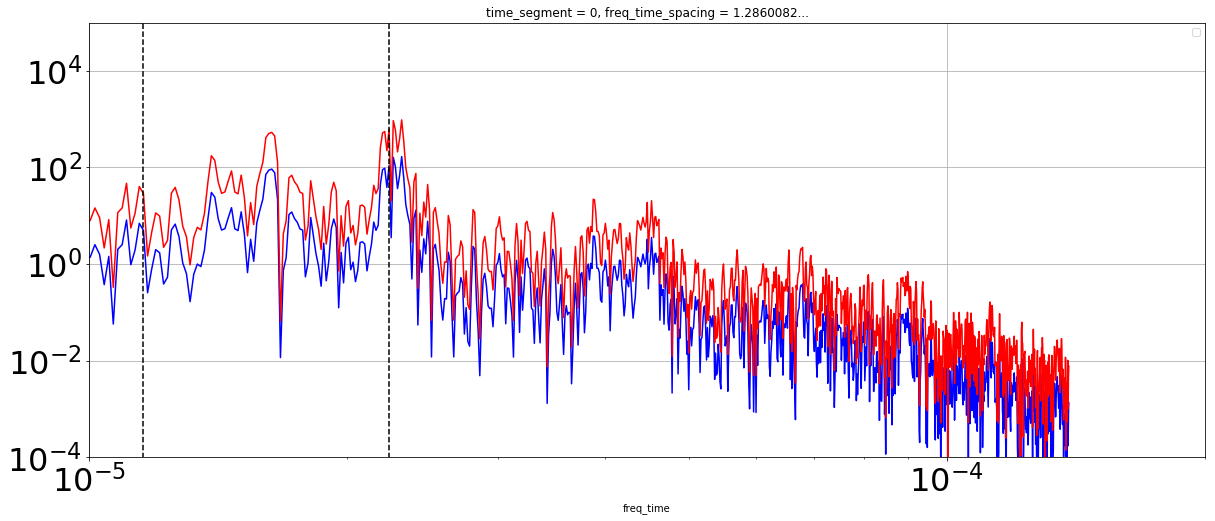

In [51]:
fig, ax = plt.subplots(figsize=(20,8))
E_1_segments.isel(time_segment = 0).where(E_1.freq_time>0).plot(ax=ax,color='blue')
E_uv_segments.isel(time_segment = 0).where(E_2.freq_time>0).plot(ax=ax,color='red')

ax.legend(); ax.grid()
ax.set_xscale('log'); ax.set_yscale('log')
ax.set_ylabel(''); 

ax.set_xlim([1e-5,2*1e-4])
ax.set_ylim([1e-4,1e5])


# M2 #
ax.plot([1/12.42/3600,1/12.42/3600],[1e-5,1e5],'k--') 

# K1 #
ax.plot([1/24/3600,1/24/3600],[1e-5,1e5],'k--')

ax.tick_params(labelsize=32)

In [53]:
cluster.scheduler.close()

<Future finished result=None>